## Introduction to Natural Language Processing tasks  
#### An Introduction to Word Embeddings

In [0]:
!pip install -U -q spacy gensim

Looking in indexes: https://nexus.rbinternational.corp/nexus/repository/aaws-pypi-host/simple, https://nexus.rbinternational.corp/nexus/repository/pypi-proxy/simple


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
%matplotlib inline

import os
import csv
import spacy

Many people would say the breakthrough of deep learning in Natural Language Processing started with the introduction of word embeddings. Rather than using the words themselves as features, neural network methods typically take as input dense, relatively low-dimensional vectors that model the meaning and usage of a word. Word embeddings were first popularized through the [Word2Vec](https://arxiv.org/abs/1301.3781) model, developed by Thomas Mikolov and colleagues at Google. Since then, scores of alternative approaches have been developed, such as [GloVe](https://nlp.stanford.edu/projects/glove/) and [FastText](https://fasttext.cc/) embeddings. In this notebook, we'll explore word embeddings with the original Word2Vec approach, as implemented in the [Gensim](https://radimrehurek.com/gensim/) library.

## Training word embeddings

Training word embeddings with Gensim couldn't be easier. The only thing we need is a corpus of sentences in the language under investigation. For our experiments, we're going to use the abstracts of all ArXiv papers in the category cs.CL (computation and language) that were published before mid-April 2021 — a total of around 25,000 documents. We tokenize these abstracts with spaCy.

In [0]:
class Corpus(object):

    def __init__(self, filename):
        self.filename = filename
        self.nlp = spacy.blank("en")
        
    def __iter__(self):
        with open(self.filename, "r") as i:
            reader = csv.reader(i, delimiter=",")
            for _, abstract in reader:
                tokens = [t.text.lower() for t in self.nlp(abstract)]
                yield tokens
                            
                    
documents = Corpus(os.path.join(os.getcwd(), "data/arxiv/arxiv.csv"))

When we train our word embeddings, gensim allows us to set a number of parameters. The most important of these are `min_count`, `window`, `vector_size` and `sg`:

- `min_count` is the minimum frequency of the words in our corpus. For infrequent words, we just don't have enough information to train reliable word embeddings. It therefore makes sense to set this minimum frequency to at least 10. In these experiments, we'll set it to 100 to limit the size of our model even more.
- `window` is the number of words to the left and to the right that make up the context that word2vec will take into account.
- `vector_size` is the dimensionality of the word vectors. This is generally between 100 and 1000. This dimensionality often forces us to make a trade-off: embeddings with a higher dimensionality are able to model more information, but also need more data to train.
- `sg`: there are two algorithms to train word2vec: skip-gram and CBOW. Skip-gram tries to predict the context on the basis of the target word; CBOW tries to find the target on the basis of the context. By default, Gensim uses CBOW (`sg=0`).

We'll investigate the impact of some of these parameters later.

In [0]:
import gensim

model = gensim.models.Word2Vec(documents, min_count=100, window=5, vector_size=100)

## Using word embeddings

Let's take a look at the trained model. The word embeddings are on its `wv` attribute, and we can access them by the using the token as key. For example, here is the embedding for *nlp*, with the requested 100 dimensions.

In [0]:
model.wv["nlp"]

Out[20]: array([ 1.6091166 , -1.9936911 ,  1.1678154 , -0.59087276,  1.073703  ,
       -0.0084076 ,  1.0418856 ,  1.5158463 ,  0.08755157,  2.494016  ,
        1.023353  , -2.2181728 ,  0.78320706,  0.09745053, -1.10562   ,
       -0.39821097, -1.181543  ,  1.4482156 ,  0.15140046,  2.4200435 ,
        1.0063447 , -0.01121101,  0.53986937,  0.03580813, -3.2522457 ,
       -1.5299978 ,  1.3274472 ,  0.80947185,  1.2546419 , -1.1713006 ,
        1.0476595 , -0.08455472,  1.2779464 ,  0.9970837 ,  0.81702733,
       -0.57873666, -1.3166683 , -3.9538748 , -0.3761671 ,  2.0567703 ,
       -1.304386  , -0.91882515,  2.6852932 ,  0.395619  , -2.4457788 ,
        0.3125227 ,  0.41690114,  1.6897303 ,  0.40962705, -2.9978642 ,
        1.5085285 ,  0.40223256,  0.9428551 ,  0.53113824,  0.13545065,
        0.61321574, -0.17988648,  1.5774989 ,  3.7214298 ,  0.2646548 ,
       -0.5458092 ,  2.3526394 , -2.5311205 ,  0.1532534 ,  0.08826462,
        0.2599458 , -0.7510663 , -2.834408  ,  1.499507

We can also easily find the similarity between two words. Similarity is measured as the cosine between the two word embeddings, and therefore ranges between -1 and +1. The higher the cosine, the more similar two words are. As expected, the figures below show that *nmt* (neural machine translation) is closer to *smt* (statistical machine translation) than to *ner* (named entity recognition).

In [0]:
print(model.wv.similarity("nmt", "smt"))
print(model.wv.similarity("nmt", "ner"))

0.6695265
0.4057429


In a similar vein, we can find the words that are most similar to a target word. The words with the most similar embedding to *bert* are all semantically related to it: other types of pretrained models such as *roberta*, *mbert*, *xlm*, as well as the more general model type BERT represents (*transformer* and *transformers*), and more generally related words (*pretrained*).

In [0]:
model.wv.similar_by_word("bert", topn=10)

Out[22]: [('roberta', 0.7915335893630981),
 ('transformer', 0.7451812028884888),
 ('transformers', 0.7399031519889832),
 ('elmo', 0.7363311052322388),
 ('pretrained', 0.6982702016830444),
 ('gpt-2', 0.6485012769699097),
 ('mbert', 0.6462222933769226),
 ('xlm', 0.6352600455284119),
 ('xlnet', 0.622956395149231),
 ('lstm', 0.6215007305145264)]

Interestingly, we can look for words that are similar to a set of words and dissimilar to another set of words at the same time. This allows us to look for analogies of the type *BERT is to a transformer like an LSTM is to ...*. Our embedding model correctly predicts that LSTMs are a type of RNN, just like BERT is a particular type of transformer.

In [0]:
model.wv.most_similar(positive=["transformer", "lstm"], negative=["bert"], topn=1)

Out[31]: [('rnn', 0.8030800223350525)]

Similarly, we can also zoom in on one of the meanings of ambiguous words. For example, in NLP *tree* has a very specific meaning, which is obvious from its nearest neighbours *constituency*, *parse*, *dependency* and *syntax*.

In [0]:
model.wv.most_similar(positive=["tree"], topn=10)

Out[24]: [('trees', 0.7946162223815918),
 ('constituency', 0.7145154476165771),
 ('parse', 0.6837285161018372),
 ('recursive', 0.6739325523376465),
 ('dependency', 0.6453956365585327),
 ('syntax', 0.6300259232521057),
 ('constituent', 0.6246241331100464),
 ('parser', 0.5867713689804077),
 ('grammars', 0.5820275545120239),
 ('hierarchical', 0.5801476240158081)]

However, if we specify we're looking for words that are similar to *tree*, but dissimilar to *syntax*, suddenly its standard meaning takes over, and *forest* crops up in its nearest neighbours.

In [0]:
model.wv.most_similar(positive=["tree"], negative=["syntax"], topn=10)

Out[25]: [('forest', 0.46445491909980774),
 ('crf', 0.41354069113731384),
 ('softmax', 0.41056933999061584),
 ('normalized', 0.4062279164791107),
 ('greedy', 0.4038805663585663),
 ('logistic', 0.3994589149951935),
 ('neighbor', 0.3853846788406372),
 ('bayes', 0.3837711215019226),
 ('naive', 0.3724498748779297),
 ('binary', 0.37116098403930664)]

Finally, we can present the word2vec model with a list of words and ask it to identify the odd one out. It then uses the word embeddings to identify the word that is least similar to the other ones. For example, in the list *lstm cnn gru svm transformer*, it correctly identifies *svm* as the only non-neural model. In the list *bert word2vec gpt-2 roberta xlnet*, it correctly singles out *word2vec* as the only non-transormer model. In *word2vec bert glove fasttext elmo*, *bert* is singled out as the only transformer.

In [0]:
print(model.wv.doesnt_match("lstm cnn gru svm transformer".split()))
print(model.wv.doesnt_match("bert word2vec gpt-2 roberta xlnet".split()))
print(model.wv.doesnt_match("word2vec bert glove fasttext elmo".split()))

svm
word2vec
bert


## Plotting embeddings

Let's now visualize some of our embeddings. To plot embeddings with a dimensionality of 100 or more, we first need to map them to a dimensionality of 2. We do this with the popular [t-SNE](https://lvdmaaten.github.io/tsne/) method. T-SNE, short for t-distributed Stochastic Neighbor Embedding, helps us visualize high-dimensional data by mapping similar data to nearby points and dissimilar data to distance points in the low-dimensional space.

T-SNE is present in [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). To run it, we just have to specify the number of dimensions we'd like to map the data to (`n_components`), and the similarity metric that t-SNE should use to compute the similarity between two data points (`metric`). We're going to map to 2 dimensions and use the cosine as our similarity metric. Additionally, we use PCA as an initialization method to remove some noise and speed up computation. The [Scikit-learn user guide](https://scikit-learn.org/stable/modules/manifold.html#t-sne) contains some additional tips for optimizing performance. 

Plotting all the embeddings in our vector space would result in a very crowded figure where the labels are hardly legible. Therefore we'll focus on a subset of embeddings by selecting the 200 most similar words to a target word.

In [0]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

target_word = "bert"
selected_words = [w[0] for w in model.wv.most_similar(positive=[target_word], topn=200)] + [target_word]
embeddings = [model.wv[w] for w in selected_words] + model.wv["bert"]

mapped_embeddings = TSNE(n_components=2, metric='cosine', init='pca').fit_transform(embeddings)

/databricks/python/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


If we take *bert* as our target word, the figure shows some interesting patterns. In the immediate vicinity of *bert*, we find the similar transformer models that we already identified as its nearest neighbours earlier: *xlm*, *mbert*, *gpt-2*, and so on. Other parts of the picture have equally informative clusters of NLP tasks and benchmarks (*squad* and *glue*), languages (*german* and *english*), neural-network architectures (*lstm*, *gru*, etc.), embedding types (*word2vec*, *glove*, *fasttext*, *elmo*), etc.

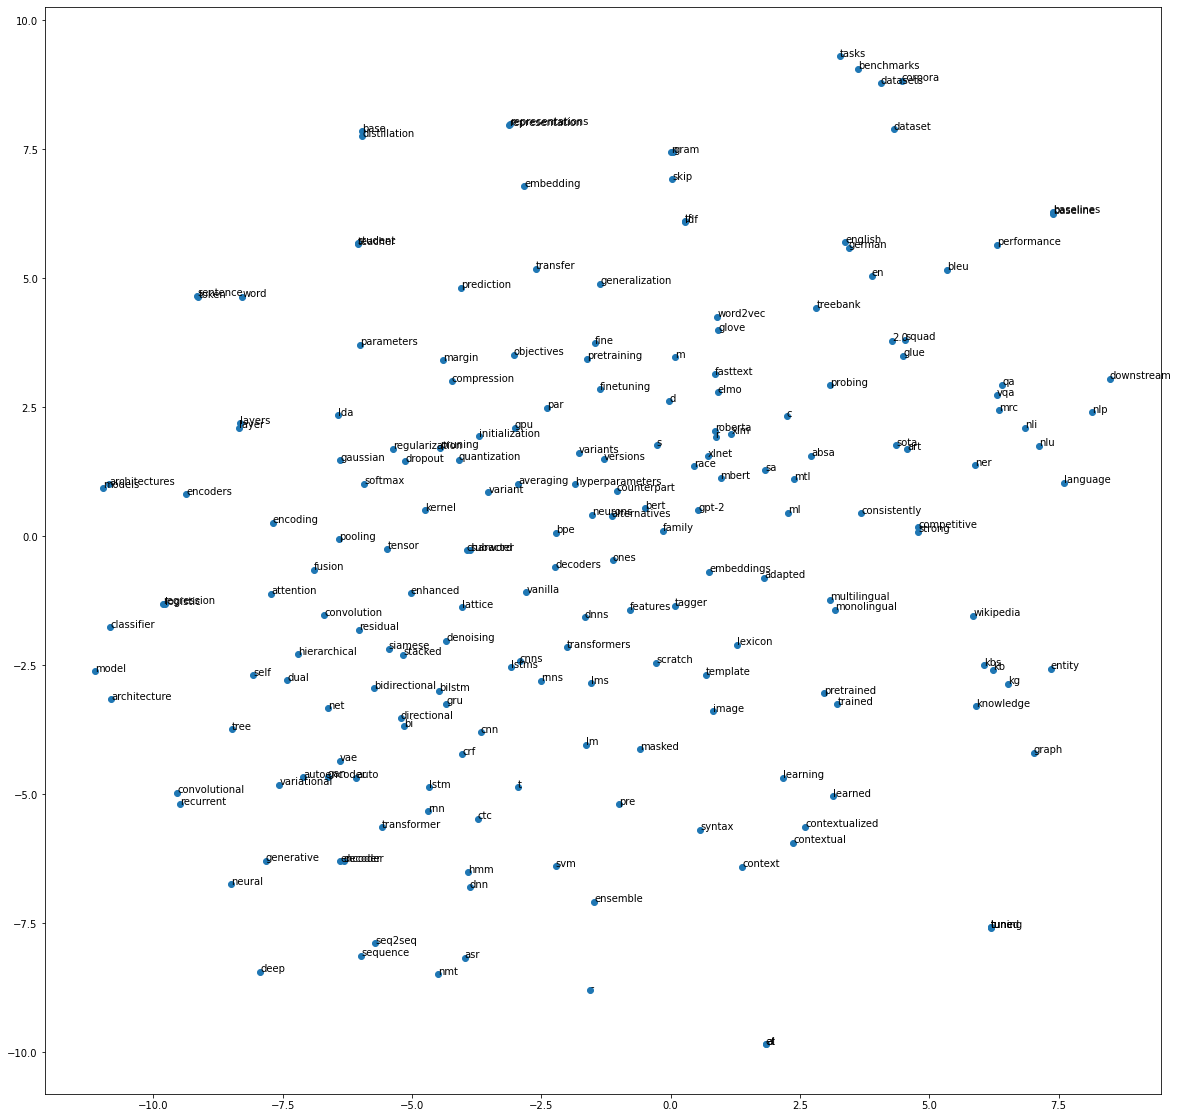

In [0]:
plt.figure(figsize=(20,20))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
plt.scatter(x, y)

for i, txt in enumerate(selected_words):
    plt.annotate(txt, (x[i], y[i]))

## Exploring hyperparameters

We mentioned above there are a number of parameters we can set when training our embeddings. Let's investigate the impact some of these have on the result. Quantifying the quality of embeddings is a hard task. There exist quite a few data sets for [evaluating the quality of English embeddings](https://github.com/kudkudak/word-embeddings-benchmarks), but this is not the case for other languages or very specialized domains, such as NLP. Moreover, it's unclear what information good embeddings should capture. Should they model syntactic information as well as semantic knowledge? Should they capture semantic similarity, or merely topical relatedness? Often, the answer depends on the end task you want to use the embeddings for. 

Here we'll use a simple method for evaluating our embeddings. We'll count how many times two nearest neighbours in the vector space have the same part of speech. After all, if our embeddings model similarity (and not just relatedness) in meaning, we expect a noun to have another noun as nearest neighbour, and the same for verbs, adjectives, and so on.

First we'll use [spaCy](https://spacy.io/) to determine the part of speech of all the words in our vocabulary. Note that our evaluation metric does rely on the quality of spaCy's part-of-speech tagging, which may not be very accurate for low-frequency words out of context. Nevertheless, we'll assume it's good enough for our purposes.

In [0]:
#!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

Looking in indexes: https://nexus.rbinternational.corp/nexus/repository/aaws-pypi-host/simple, https://nexus.rbinternational.corp/nexus/repository/pypi-proxy/simple
ERROR: Could not install packages due to an OSError: HTTPSConnectionPool(host='github.com', port=443): Max retries exceeded with url: /explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1129)')))



In [0]:
import spacy
from tqdm.notebook import tqdm

nlp = spacy.load("en_core_web_sm")

word2pos = {}
for word in tqdm(model.wv.key_to_index):
    word2pos[word] = nlp(word)[0].pos_

word2pos["translation"]

Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/databricks/python/lib/python3.9/site-packages/urllib3/connectionpool.py", line 382, in _make_request
    self._validate_conn(conn)
  File "/databricks/python/lib/python3.9/site-packages/urllib3/connectionpool.py", line 1010, in _validate_conn
    conn.connect()
  File "/databricks/python/lib/python3.9/site-packages/urllib3/connection.py", line 416, in connect
    self.sock = ssl_wrap_socket(
  File "/databricks/python/lib/python3.9/site-packages/urllib3/util/ssl_.py", line 449, in ssl_wrap_socket
    ssl_sock = _ssl_wrap_socket_impl(
  File "/databricks/python/lib/python3.9/site-packages/urllib3/util/ssl_.py", line 493, in _ssl_wrap_socket_impl
    return ssl_context.wrap_socket(sock, server_hostname=server_hostname)
  File "/usr/lib/python3.9/ssl.py", line 500, in wrap_socket
    return self.sslso

---------------------------------------------------------------------------
OSError                                   Traceback (most recent call last)
<command-4473113267812608> in <cell line: 5>()
      3 from tqdm.notebook import tqdm
      4 
----> 5 nlp = spacy.load("en_core_web_sm")
      6 
      7 word2pos = {}

/databricks/python/lib/python3.9/site-packages/spacy/__init__.py in load(name, vocab, disable, exclude, config)
     49     RETURNS (Language): The loaded nlp object.
     50     """
---> 51     return util.load_model(
     52         name, vocab=vocab, disable=disable, exclude=exclude, config=config
     53     )

/databricks/python/lib/python3.9/site-packages/spacy/util.py in load_model(name, vocab, disable, exclude, config)
    425     if name in OLD_MODEL_SHORTCUTS:
    426         raise IOError(Errors.E941.format(name=name, full=OLD_MODEL_SHORTCUTS[name]))  # type: ignore[index]
--> 427     raise IOError(Errors.E050.format(name=name))
    428 
    429 

OSError: [E

Then we write a simple method that takes a model and looks up the nearest neighbour to every word in its vocabulary. It returns the number of times this nearest neighbour has the same part of speech: a percentage we'll call the accuracy.

In [0]:
import numpy as np

def evaluate(model, word2pos):
    same = 0
    for word in tqdm(model.wv.key_to_index):
        most_similar = model.wv.similar_by_word(word, topn=1)[0][0]
        if word2pos[most_similar] == word2pos[word]:
            same += 1
    return same/len(model.wv.key_to_index)
       
evaluate(model, word2pos)

Now we vary some of the settings we introduced above. In particular we're interested in the influence of embedding size (the dimensionality of the trained embeddings), and the size of the context window. We vary the embedding size between 100, 200 and 300,and the context window between 2, 5 and 10. This means we'll train 9 models in total, which obviously takes a bit of time. Feel free to go grab a coffee.

In [0]:
sizes = [100, 200, 300]
windows = [2,5,10]

df = pd.DataFrame(index=windows, columns=sizes)

for size in sizes:
    for window in windows:
        print("Size:", size, "Window:", window)
        model = gensim.models.Word2Vec(documents, min_count=100, window=window, vector_size=size)
        acc = evaluate(model, word2pos)
        df[size][window] = acc
        
df

Although the accuracies of all models are very similar, the results do show some interesting patterns. 

First, it looks like smaller contexts work better than larger ones. This is logical, as our evaluation metric is a syntactic one: the closest context words contain much more useful information about the part of speech of a word than those further away. 

Second, higher-dimensional word embeddings do not necessarily work better than lower-dimensional ones. This may sound counter-intuitive, as higher-dimensional embeddings are able to capture more information. Still, larger embeddings also require more data, while we're using a pretty small corpus.

In [0]:
df.plot()

## Conclusions

Word embeddings are one of the most exciting trends on Natural Language Processing since the 2000s. They allow us to model the meaning and usage of a word, and discover words that behave similarly. This is crucial for the generalization capacity of many machine learning models. Moving from raw strings to embeddings allows them to generalize across words that have a similar meaning, and discover patterns that had previously escaped them.